In [13]:
#!pip install flowvision
#!pip install captcha

In [1]:
import oneflow as flow
import oneflow.nn as nn
import oneflow.nn.functional as F
from oneflow.utils.data import Dataset, DataLoader
from flowvision.transforms.functional import to_tensor, to_pil_image

from captcha.image import ImageCaptcha
from tqdm import tqdm
import random
import numpy as np
from collections import OrderedDict
import string



loaded library: /usr/lib/x86_64-linux-gnu/libibverbs.so.1


In [2]:
characters = '-' + string.digits + string.ascii_letters
width, height, n_len, n_classes = 192, 64, 4, len(characters)
n_input_length = 12
print(characters, width, height, n_len, n_classes)

-0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ 192 64 4 63


In [3]:
class CaptchaDataset(Dataset):
    def __init__(self, characters, length, width, height, input_length, label_length):
        super(CaptchaDataset, self).__init__()
        self.characters = characters
        self.length = length
        self.width = width
        self.height = height
        self.input_length = input_length
        self.label_length = label_length
        self.n_class = len(characters)
        self.generator = ImageCaptcha(width=width, height=height)

    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        random_str = ''.join([random.choice(self.characters[1:]) for j in range(self.label_length)])
        image = to_tensor(self.generator.generate_image(random_str))
        target = flow.tensor([self.characters.find(x) for x in random_str], dtype=flow.long)
        input_length = flow.full(size=(1, ), value=self.input_length, dtype=flow.long)
        target_length = flow.full(size=(1, ), value=self.label_length, dtype=flow.long)
        return image, target, input_length, target_length

Az6V tensor([12], dtype=oneflow.int64) tensor([4], dtype=oneflow.int64)


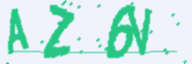

In [4]:
dataset = CaptchaDataset(characters, 1, width, height, n_input_length, n_len)
image, target, input_length, label_length = dataset[0] # X： img, y:index in characters
print(''.join([characters[x] for x in target]), input_length, label_length)
to_pil_image(image)

In [5]:
batch_size = 128
train_set = CaptchaDataset(characters, 1000 * batch_size, width, height, n_input_length, n_len)
valid_set = CaptchaDataset(characters, 100 * batch_size, width, height, n_input_length, n_len)
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=12)
valid_loader = DataLoader(valid_set, batch_size=batch_size, num_workers=12)

In [6]:
class Model(nn.Module):
    def __init__(self, n_classes, input_shape=(3, 64, 192)):
        super(Model, self).__init__()
        self.input_shape = input_shape
        channels = [32, 64, 128, 256, 256]
        layers = [2, 2, 2, 2, 2]
        pools = [2, 2, 2, 2, (2, 1)]

        def block(num_convs, in_channels, out_channels):
            lys = []
            for _ in range(num_convs):
                lys.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=(1, 1)))
                lys.append(nn.BatchNorm2d(out_channels))
                lys.append(nn.ReLU(inplace=True))
                in_channels = out_channels
            return nn.Sequential(*lys)

        convs_blks = []
        last_channels = 3
        for  (num_convs, out_channels, k_pool) in zip( layers, channels, pools):
            convs_blks.append(block(num_convs, last_channels,out_channels))
            last_channels = out_channels
            convs_blks.append(nn.MaxPool2d(k_pool))
        
        self.cnn = nn.Sequential(*convs_blks,nn.Dropout(0.25, inplace=True),)
        self.lstm = nn.LSTM(input_size=self.infer_features(), hidden_size=128, num_layers=2, bidirectional=True)
        self.fc = nn.Linear(in_features=256, out_features=n_classes)
    
    def infer_features(self):
        x = flow.zeros((1,)+self.input_shape)
        x = self.cnn(x)
        x = x.reshape(x.shape[0], -1, x.shape[-1])
        return x.shape[1]

    def forward(self, x):
        x = self.cnn(x)
        x = x.reshape(x.shape[0], -1, x.shape[-1])
        x = x.permute(2, 0, 1)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

In [7]:
model = Model(n_classes, input_shape=(3, height, width)).cuda()
inputs = flow.zeros((32, 3, height, width)).cuda()
outputs = model(inputs)
outputs.shape

oneflow.Size([12, 32, 63])

In [243]:
def rm_dup(s):
    for i in range(len(s)-1):
        if (s[i] == s[i+1] and s[i]!='-'):
            s = np.delete(s,i)
            return s
    
    return s[s!='-'][:4]
def decode(sequence):
    s = np.array([characters[x]  for x in sequence])
    while((s !='-').sum()>4):
        s = rm_dup(s)
    #print(a)
    # s = ''.join([x for j, x in enumerate(a[:-1]) if x != characters[0] and x != a[j+1]])
    #s = a.replace('-','')
    #print(s)
    s =s[s!='-']
    if len(s) == 0:
        return ''
    #if a[-1] != characters[0] and s[-1] != a[-1]:
    #    s += a[-1]
    return ''.join(s)

def decode_target(sequence):
    return ''.join([characters[x] for x in sequence]).replace(' ', '')

def calc_acc(target, output):
    output_argmax = output.detach().permute(1, 0, 2).argmax(dim=-1)
    target = target.cpu().numpy()
    output_argmax = output_argmax.cpu().numpy()
    a = np.array([decode_target(true) == decode(pred) for true, pred in zip(target, output_argmax)])
    return a.mean()

In [9]:
def train(model, optimizer, epoch, dataloader):
    model.train()
    loss_mean = 0
    acc_mean = 0
    with tqdm(dataloader) as pbar:
        for batch_index, (data, target, input_lengths, target_lengths) in enumerate(pbar):
            data, target, = data.cuda(), target.cuda().int()
            #input_lengths, target_lengths = input_lengths.cuda(), target_lengths.cuda()
            input_lengths, target_lengths = input_lengths.cuda().reshape(-1), target_lengths.cuda().reshape(-1)
            optimizer.zero_grad()
            output = model(data)
            
            output_log_softmax =F.log_softmax(output, dim=-1)
            # oneflow的fucntional中没有，需要从nn导入CTCLss类

            ctc_loss = nn.CTCLoss()
            
            #print(output_log_softmax.shape)
            #return output_log_softmax, target, input_lengths, target_lengths
            #print(output_log_softmax.dtype, target.dtype, input_lengths.dtype, target_lengths.dtype)
            loss = ctc_loss(output_log_softmax, target, input_lengths, target_lengths)    
            
            loss.backward()
            optimizer.step()

            loss = loss.item()
            acc = calc_acc(target, output)
            
            if batch_index == 0:
                loss_mean = loss
                acc_mean = acc
            
            loss_mean = 0.1 * loss + 0.9 * loss_mean
            acc_mean = 0.1 * acc + 0.9 * acc_mean
            
            pbar.set_description(f'Epoch: {epoch} Loss: {loss_mean:.4f} Acc: {acc_mean:.4f} ')

def valid(model, optimizer, epoch, dataloader):
    model.eval()
    with tqdm(dataloader) as pbar, flow.no_grad():
        loss_sum = 0
        acc_sum = 0
        for batch_index, (data, target, input_lengths, target_lengths) in enumerate(pbar):
            data, target = data.cuda(), target.cuda().int()
            input_lengths, target_lengths = input_lengths.cuda().reshape(-1), target_lengths.cuda().reshape(-1)
            output = model(data)
            output_log_softmax = F.log_softmax(output, dim=-1)
            ctc_loss = nn.CTCLoss()
            loss = ctc_loss(output_log_softmax, target, input_lengths, target_lengths)
            

            loss = loss.item()
            acc = calc_acc(target, output)
            
            loss_sum += loss
            acc_sum += acc
            
            loss_mean = loss_sum / (batch_index + 1)
            acc_mean = acc_sum / (batch_index + 1)
            
            pbar.set_description(f'Test : {epoch} Loss: {loss_mean:.4f} Acc: {acc_mean:.4f} ')

In [12]:
optimizer = flow.optim.Adam(model.parameters(), 1e-3, amsgrad=True)
epochs = 2
for epoch in range(1, epochs + 1):
    train(model, optimizer, epoch, train_loader)
    valid(model, optimizer, epoch, valid_loader)

Test : 2 Loss: 0.0763 Acc: 0.8977 : 100%|██████████| 100/100 [00:22<00:00,  4.37it/s]


In [13]:
optimizer = flow.optim.Adam(model.parameters(), 1e-4, amsgrad=True)
epochs = 3
for epoch in range(1, epochs + 1):
    train(model, optimizer, epoch, train_loader)
    valid(model, optimizer, epoch, valid_loader)

Test : 3 Loss: 0.0201 Acc: 0.9566 : 100%|██████████| 100/100 [00:22<00:00,  4.38it/s]


In [15]:
flow.save(model.state_dict(), "./model_lower")

In [16]:
params = flow.load("./model_lower")
model.load_state_dict(params)

<All keys matched successfully>

true: r6hj
pred: r6hj
true: HXkM
pred: HXkM
true: C1Hy
pred: C1Hy
true: BhKG
pred: BhKG
true: pVTI
pred: pVTI
true: bBp3
pred: bBp3
true: 2LDO
pred: 2LDO
true: eu01
pred: eu01
true: YG38
pred: YG38
true: JbsO
pred: JbsO
true: 0sGL
pred: 0sGL
true: HO7I
pred: HO7I
true: BwrZ
pred: BwrZ
true: Gt3P
pred: Gt3P
true: HNj4
pred: HNj4
true: 4EYX
pred: 4EYX
true: NXUb
pred: NXUb
true: Zd5A
pred: Zd5A
true: rA34
pred: rA34
true: h3rF
pred: h3rF
true: t0p7
pred: t0p7
true: GsFx
pred: GsFx
true: f1gs
pred: f1gs
true: 7c4o
pred: 7c4o
true: xBVY
pred: xBVY
true: GZbQ
pred: GZbQ
true: C840
pred: C840
true: 5iVz
pred: 5iVz
true: 2aIX
pred: 2aIX
true: 33v8
pred: 33V8


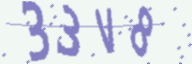

In [246]:
#
model.eval()
do = True
while do or decode_target(target) == decode(output_argmax[0]):
    do = False
    image, target, input_length, label_length = dataset[0]


    
    print('true:', decode_target(target))

    output = model(image.unsqueeze(0).cuda())
    output_argmax = output.detach().permute(1, 0, 2).argmax(dim=-1)
    print('pred:', decode(output_argmax[0]))
to_pil_image(image)

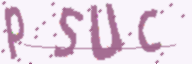

In [242]:
 image, target, input_length, label_length = dataset[0]
 to_pil_image(image)


In [233]:
output = model(image.unsqueeze(0).cuda())
output_argmax = output.detach().permute(1, 0, 2).argmax(dim=-1)
output_argmax

tensor([[55, 25, 53,  0,  0,  0,  0,  0,  0,  0,  0, 30]], device='cuda:0',
       dtype=oneflow.int64)

In [174]:
decode(output_argmax[0])

'JNGG'